In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:

data = pd.read_csv("/content/drive/MyDrive/user1_data.csv")

In [118]:
data.head()

,ttime,pm1,pm2,pm3,am,sm,st,lum
0,2022-07-18 15:42:55,3.63,0.0,0.0,3.2,7813.0,25.65,15001.0
1,2022-07-18 15:47:55,4.19,0.0,0.0,4.8,7692.0,25.66,13863.0
2,2022-07-18 15:52:55,4.74,0.0,0.0,4.0,7813.0,25.67,13788.0
3,2022-07-18 15:57:55,5.30,0.0,0.0,4.8,7813.0,25.68,14383.0
4,2022-07-18 16:02:55,0.55,5.3,5.3,3.2,7813.0,25.69,14621.0


In [119]:
data['sm'].value_counts()

6757.0    1622
6667.0    1536
6849.0    1206
6579.0    1011
6410.0     717
          ... 
898.0        1
723.0        1
1441.0       1
904.0        1
850.0        1
Name: sm, Length: 939, dtype: int64

In [120]:
df = data
df.head()

,ttime,pm1,pm2,pm3,am,sm,st,lum
0,2022-07-18 15:42:55,3.63,0.0,0.0,3.2,7813.0,25.65,15001.0
1,2022-07-18 15:47:55,4.19,0.0,0.0,4.8,7692.0,25.66,13863.0
2,2022-07-18 15:52:55,4.74,0.0,0.0,4.0,7813.0,25.67,13788.0
3,2022-07-18 15:57:55,5.30,0.0,0.0,4.8,7813.0,25.68,14383.0
4,2022-07-18 16:02:55,0.55,5.3,5.3,3.2,7813.0,25.69,14621.0


In [121]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['ttime'])
df = df.loc[df['datetime'] > pd.to_datetime('2022-06-01 00:00:00')]

In [122]:
df = df[['datetime', 'pm1', 'pm2',  'pm3', 'am','sm','st','lum']]

In [123]:
df.head(5)

,datetime,pm1,pm2,pm3,am,sm,st,lum
0,2022-07-18 15:42:55,3.63,0.0,0.0,3.2,7813.0,25.65,15001.0
1,2022-07-18 15:47:55,4.19,0.0,0.0,4.8,7692.0,25.66,13863.0
2,2022-07-18 15:52:55,4.74,0.0,0.0,4.0,7813.0,25.67,13788.0
3,2022-07-18 15:57:55,5.30,0.0,0.0,4.8,7813.0,25.68,14383.0
4,2022-07-18 16:02:55,0.55,5.3,5.3,3.2,7813.0,25.69,14621.0


In [124]:
df.shape

(18944, 8)

In [125]:
df = df[[ 'sm']]

In [126]:
dataset = df.values
dataset = dataset.astype('float32')

In [127]:
dataset

array([[7813.],
       [7692.],
       [7813.],
       ...,
       [ 287.],
       [ 292.],
       [ 292.]], dtype=float32)

In [128]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#dataset1 = dataset[0:231,:]
dataset

array([[9.8379087e-01],
       [9.6797383e-01],
       [9.8379087e-01],
       ...,
       [0.0000000e+00],
       [6.5359473e-04],
       [6.5359473e-04]], dtype=float32)

In [129]:
dataset
datasetr = []
for x in range(len(dataset)):
  if(dataset[x] >= 0.5 ):
    datasetr.append(1)
  else:
    datasetr.append(0)
datasetm = []
for x in range(18891):
  datasetm.append(datasetr[x])
#datasetr = datasetr[0:479,:]
len(datasetm)

18891

In [141]:
train_size = int(len(dataset) * 0.99779)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

18902 42


In [142]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [143]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [144]:
len(trainX)

18891

In [145]:
len(testX)

31

In [146]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [147]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Epoch 1/100
74/74 - 2s - loss: 0.1765 - 2s/epoch - 33ms/step
Epoch 2/100
74/74 - 0s - loss: 0.0095 - 184ms/epoch - 2ms/step
Epoch 3/100
74/74 - 0s - loss: 0.0031 - 192ms/epoch - 3ms/step
Epoch 4/100
74/74 - 0s - loss: 0.0016 - 189ms/epoch - 3ms/step
Epoch 5/100
74/74 - 0s - loss: 8.0390e-04 - 177ms/epoch - 2ms/step
Epoch 6/100
74/74 - 0s - loss: 4.7774e-04 - 183ms/epoch - 2ms/step
Epoch 7/100
74/74 - 0s - loss: 3.5500e-04 - 193ms/epoch - 3ms/step
Epoch 8/100
74/74 - 0s - loss: 3.1255e-04 - 190ms/epoch - 3ms/step
Epoch 9/100
74/74 - 0s - loss: 2.9675e-04 - 195ms/epoch - 3ms/step
Epoch 10/100
74/74 - 0s - loss: 2.8813e-04 - 235ms/epoch - 3ms/step
Epoch 11/100
74/74 - 0s - loss: 2.8148e-04 - 201ms/epoch - 3ms/step
Epoch 12/100
74/74 - 0s - loss: 2.7552e-04 - 206ms/epoch - 3ms/step
Epoch 13/100
74/74 - 0s - loss: 2.6988e-04 - 181ms/epoch - 2ms/step
Epoch 14/100
74/74 - 0s - loss: 2.6468e-04 - 243ms/epoch - 3ms/step
Epoch 15/100
74/74 - 0s - loss: 2.5981e-04 - 192ms/epoch - 3ms/step
Epoch 1

In [148]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
t1 = trainPredict
len(testX)
dataset1 = []
for x in range(len(trainX)):
  dataset1.append(dataset[x])
len(dataset1)

1/1 [==============================] - 0s 36ms/step


18891

In [149]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))
trainPredict1 = []
print(len(trainPredict))
scaler1 = MinMaxScaler(feature_range=(0, 1))
trainPredictr = scaler1.fit_transform(trainPredict)
print(len(trainPredictr))
for x in range(len(trainPredictr)):
  if(trainPredictr[x] >= 0.5 ):
    trainPredict1.append(1)
  else:
    trainPredict1.append(0)
trainPredict1

Train Score: 86.19 RMSE
Test Score: 16.13 RMSE
18891
18891


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


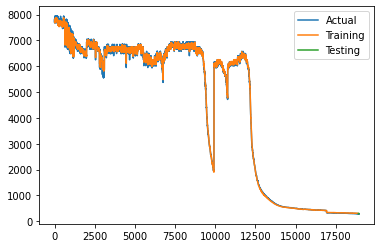

18944

In [150]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict
 
plt.plot(df['sm'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()
#len(trainPredictPlot)
len(testPredictPlot)

In [151]:

confusion_matrix = confusion_matrix(datasetm,trainPredict1)

confusion_matrix

array([[ 7121,     6],
       [    9, 11755]])

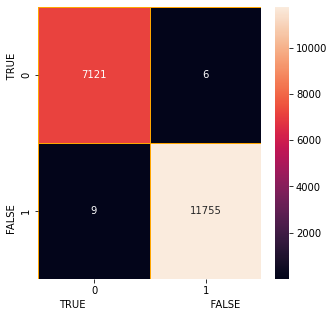

In [152]:
f, ax =plt.subplots(figsize = (5,5))

sns.heatmap(confusion_matrix,annot = True, linewidths= 0.5, linecolor="orange", fmt=".0f", ax=ax)
plt.xlabel("TRUE                                        FALSE")
plt.ylabel("FALSE                                        TRUE")
plt.show()

In [153]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(datasetm,trainPredict1)*100))

print('Micro Precision: {:.2f}'.format(precision_score(datasetm,trainPredict1, average='micro')*100))
print('Micro Recall: {:.2f}'.format(recall_score(datasetm,trainPredict1, average='micro')*100))
print('Micro F1-score: {:.2f}\n'.format(f1_score(datasetm,trainPredict1, average='micro')*100))

print('Macro Precision: {:.2f}'.format(precision_score(datasetm,trainPredict1, average='macro')*100))
print('Macro Recall: {:.2f}'.format(recall_score(datasetm,trainPredict1, average='macro')*100))
print('Macro F1-score: {:.2f}\n'.format(f1_score(datasetm,trainPredict1, average='macro')*100))



Accuracy: 99.92

Micro Precision: 99.92
Micro Recall: 99.92
Micro F1-score: 99.92

Macro Precision: 99.91
Macro Recall: 99.92
Macro F1-score: 99.92



In [154]:
print("The data for the month of March is:")
print(testPredict)

The data for the month of March is:
[[304.89017]
 [305.7318 ]
 [306.80194]
 [308.0922 ]
 [307.92648]
 [308.1717 ]
 [307.19135]
 [306.13443]
 [305.0914 ]
 [304.95874]
 [304.8449 ]
 [305.43994]
 [306.45444]
 [307.39984]
 [307.93158]
 [308.38367]
 [308.02625]
 [306.8513 ]
 [306.31757]
 [305.06763]
 [304.95874]
 [304.8449 ]
 [305.43994]
 [306.45444]
 [307.39984]
 [307.93158]
 [308.38367]
 [308.02625]
 [306.8513 ]
 [306.31757]
 [305.06763]]
